# Random Walk Performance
# Skip notebook test¶ 

Random walk performance is governed by the length of the paths to find, the number of seeds, and the size or structure of the graph.
This benchmark will use several test graphs of increasingly larger sizes.  While not even multiples in scale, the four test graphs should give an indication of how well Random Walk performs as data size increases.  

### Test Data
Users must run the _dataPrep.sh_ script before running this notebook so that the test files are downloaded

| File Name              | Num of Vertices | Num of Edges |
| ---------------------- | --------------: | -----------: |
| preferentialAttachment |         100,000 |      999,970 |
| dblp-2010              |         326,186 |    1,615,400 |
| coPapersCiteseer       |         434,102 |   32,073,440 |
| as-Skitter             |       1,696,415 |   22,190,596 |

In [1]:
#  Import the modules
import cugraph
import cudf

In [2]:
# system and other
import gc
import os
import time
import random

# MTX file reader
from scipy.io import mmread

In [3]:
try: 
    import matplotlib
except ModuleNotFoundError:
    os.system('pip install matplotlib')

import matplotlib.pyplot as plt; plt.rcdefaults()


In [4]:
# Test File
data = {
    'preferentialAttachment' : './data/preferentialAttachment.mtx',
    'dblp'                   : './data/dblp-2010.mtx',
    'coPapersCiteseer'       : './data/coPapersCiteseer.mtx',
    'as-Skitter'             : './data/as-Skitter.mtx'
}

## Read the data and create a graph

In [5]:
# Data reader - the file format is MTX, so we will use the reader from SciPy
def read_and_create(datafile):
    print('Reading ' + str(datafile) + '...')
    M = mmread(datafile).asfptype()

    _gdf = cudf.DataFrame()
    _gdf['src'] = M.row
    _gdf['dst'] = M.col
    _gdf['wt'] = 1.0
    
    _g = cugraph.Graph()
    _g.from_cudf_edgelist(_gdf, source='src', destination='dst', edge_attr='wt', renumber=False)
    
    print("\t{:,} nodes, {:,} edges".format(_g.number_of_nodes(), _g.number_of_edges() ))
    
    return _g

### Define the call to RandomWalk
We are only interested in the runtime, so throw away the results

In [6]:
def run_rw(_G, _seeds, _depth):
    t1 = time.time()
    # cugraph.random_walks() returns a 3-tuple, which is being ignored here.
    cugraph.random_walks(_G, _seeds, _depth)
    t2 = time.time() - t1
    return t2

## Test 1: Runtime versus path depth

In [7]:
# some parameters
max_depth = 6
num_seeds = 500

# arrays to capture performance gains
names = []

# Two dimension data
time_algo_cu = []       # will be two dimensional

i = 0
for k,v in data.items():
    time_algo_cu.append([])
    
    # Saved the file Name
    names.append(k)

    # read data
    G = read_and_create(v)
        
    num_nodes = G.number_of_nodes()
    nodes = G.nodes().to_array().tolist()

    seeds = random.sample(nodes, num_seeds)

    for j in range (2, max_depth+1) :
        t = run_rw(G, seeds, j)
        time_algo_cu[i].append(t)

    # update i
    i = i + 1
    print("update i")
    
    del G


Reading ./data/preferentialAttachment.mtx...
	100,000 nodes, 499,985 edges
update i
Reading ./data/dblp-2010.mtx...
	326,183 nodes, 807,700 edges
update i
Reading ./data/coPapersCiteseer.mtx...
	434,102 nodes, 16,036,720 edges
update i
Reading ./data/as-Skitter.mtx...
	1,696,415 nodes, 11,095,298 edges
update i


In [8]:
type(nodes)

list

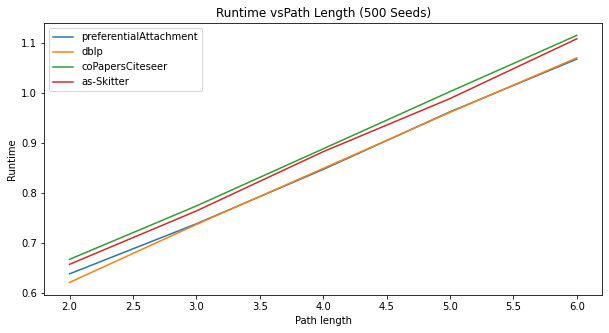

In [9]:
%matplotlib inline
seed_idx = list(range(2,max_depth +1))

plt.figure(figsize=(10,5))

for i in range(len(data)):
    plt.plot(seed_idx, time_algo_cu[i], label = names[i])


plt.title(f'Runtime vs. Path Length ({num_seeds} Seeds)')
plt.xlabel('Path length')
plt.ylabel('Runtime')
plt.legend()
plt.show()

In [10]:
del time_algo_cu
gc.collect()

12979

## Test 2: Runtime versus number of seeds
The number of seeds will be increased over a range in increments of 10.  
The runtime will be the sum of runtime per increment.  Increaing number of seeds by 1 would make for very long execution times 

In [11]:
# some parameters
rw_depth = 4
max_seeds = 1000

# arrays to capture performance gains
names = []

# Two dimension data
time_algo_cu = []       # will be two dimensional

i = 0
for k,v in data.items():
    time_algo_cu.append([])
    
    # Saved the file Name
    names.append(k)

    # read data
    G = read_and_create(v)
        
    num_nodes = G.number_of_nodes()
    nodes = G.nodes().to_array().tolist()
    
    print('\t', end='')
    for j in range (10, max_seeds +1, 10) :
        print('.', end='')
        seeds = random.sample(nodes, j+1)
        t = run_rw(G, seeds, rw_depth)
        time_algo_cu[i].append(t)

    # update i
    i = i + 1
    print(" ")
    
    del G


Reading ./data/preferentialAttachment.mtx...
	100,000 nodes, 499,985 edges
	.................................................................................................... 
Reading ./data/dblp-2010.mtx...
	326,183 nodes, 807,700 edges
	.................................................................................................... 
Reading ./data/coPapersCiteseer.mtx...
	434,102 nodes, 16,036,720 edges
	.................................................................................................... 
Reading ./data/as-Skitter.mtx...
	1,696,415 nodes, 11,095,298 edges
	.................................................................................................... 


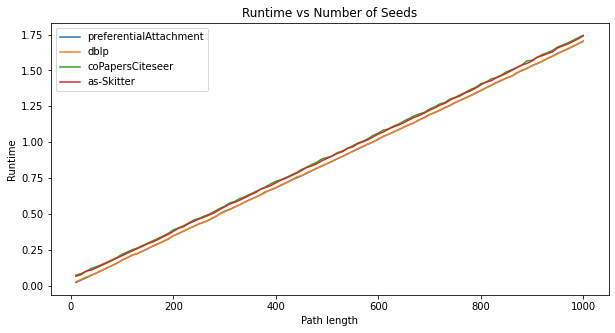

In [12]:
%matplotlib inline
seed_idx = list(range (10, max_seeds +1, 10))

plt.figure(figsize=(10,5))

for i in range(len(data)):
    plt.plot(seed_idx, time_algo_cu[i], label = names[i])


plt.title('Runtime vs. Number of Seeds')
plt.xlabel('Number of Seeds')
plt.ylabel('Runtime')
plt.legend()
plt.show()

In [13]:
del time_algo_cu
gc.collect()

4094

## Test 3: Multi-seed versus Sequential
This test uses a single files since sequential execution is slow

In [14]:
G = read_and_create('./data/coPapersCiteseer.mtx')
nodes = G.nodes().to_array().tolist()


Reading ./data/coPapersCiteseer.mtx...
	434,102 nodes, 16,036,720 edges


In [15]:
rw_depth = 4
max_seeds = 100
num_nodes = G.number_of_nodes()
runtime_seq = [0] * max_seeds

In [16]:
# sequential = so also get a single random seed
for i in range (max_seeds) :
    for j in range(i):
        seeds = random.sample(nodes, 1)
        t = run_rw(G, seeds, rw_depth)
        runtime_seq[i] = runtime_seq[i] + t

In [17]:
runtime = [None] * max_seeds

for i in range (max_seeds) :
    seeds = random.sample(nodes, i+1)
    t = run_rw(G, seeds, rw_depth)
    runtime[i] = t

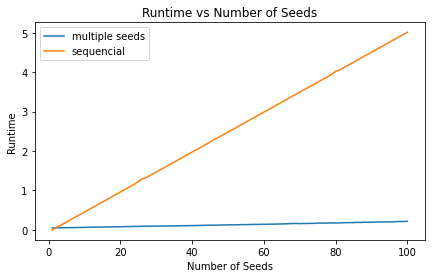

In [18]:
%matplotlib inline
seed_idx = list(range(1,max_seeds +1))


plt.figure(figsize=(7,4))
plt.plot(seed_idx, runtime, label = "multiple seeds")
plt.plot(seed_idx, runtime_seq, label = "sequential")


plt.title('Runtime vs. Number of Seeds')
plt.xlabel('Number of Seeds')
plt.ylabel('Runtime')
plt.legend()
plt.show()

-----
Copyright (c) 2021, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.